# Constantes y Logger

In [1]:
# %cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

In [2]:
SAVE_FIGS = True  # If you want to save the figures.
RUN_MCMC = False  # If you want to run the MCMC's algorithms or use saved chains

BURN = 2_000
NUM_SAMPLES = 50_000
N_WALKERS = 8

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import time

import bwb.plotters as plotters
from bwb.distributions.posterior_samplers import NUTSPosteriorSampler

In [4]:
import torch
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [5]:
from bwb import _logging as logging

log = logging.get_logger(__name__)

In [6]:
from pathlib import Path

CURR_PATH = Path().absolute()
print(f"{CURR_PATH = }")
BASE_PATH = CURR_PATH.parent.parent
print(f"{BASE_PATH = }")
DATA_PATH = BASE_PATH / "data"
print(f"{DATA_PATH = }")
NETS_PATH = BASE_PATH / "wgan_gp" / "networks" 
print(f"{NETS_PATH = }")
IMGS_PATH = CURR_PATH / "imgs" / "notebook-03"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
print(f"{IMGS_PATH = }")
MCMC_PATH = BASE_PATH / "saved_mcmc"
print(f"{MCMC_PATH = }")
NUTS_PATH = MCMC_PATH / "NUTS"
print(f"{NUTS_PATH = }")

CURR_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler')
BASE_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
DATA_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
NETS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
IMGS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler/imgs/notebook-03')
MCMC_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc')
NUTS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS')


In [7]:
from bwb.config import conf

conf.use_single_precision()
conf.set_eps(1e-20)
conf

Config(dtype=torch.float32, device=cuda:0, eps=1.00e-20)

# Sampleador de Distribuciones Posterior

Al igual que los muestreadores de distribuciones anteriores, los muestreadores a posteriori heredan de `bwb.distributions.distribution_samplers.DistributionSampler`. En este caso, tenemos a la clase abstracta
`bwb.distributions.posterior_samplers.BaseLatentMCMCPosteriorSampler` que define un MCMC utilizando la librería `hamiltorch`.

Al igual que en `bwb.distributions.distribution_samplers.GeneratorDistribSampler`, la forma de ajustar esta clase es con un generador `generator`, una transformación `transform_out`, un muestreador de ruido `noise_sampler` y datos para la posterior `data`.

## Obtener el modelo para muestrear los datos

Definimos el Dataset para obtener la primera cara y poder muestrear de ella

torch.Size([32, 32])


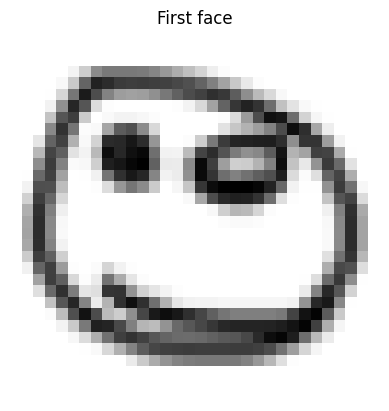

In [8]:
from quick_torch import QuickDraw
import torchvision.transforms.v2 as T
from pathlib import Path

transforms = T.Compose([
    T.ToImage(),
    T.Resize(32),
    T.ToDtype(torch.float32, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

ds = QuickDraw(
    DATA_PATH,
    categories="face",
    download=True,
    transform=transforms,
)

# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import ModelDataset

ds = ModelDataset(ds)

from bwb.distributions.distribution_samplers import UniformDiscreteSampler
ds_sampler = UniformDiscreteSampler().fit(ds)

first_face = ds.get(0)
print(first_face.shape)
_ = plotters.plot_draw(ds.get(0), title="First face")

Obtenemos una muestra y lo graficamos en un histograma

## Obtener data

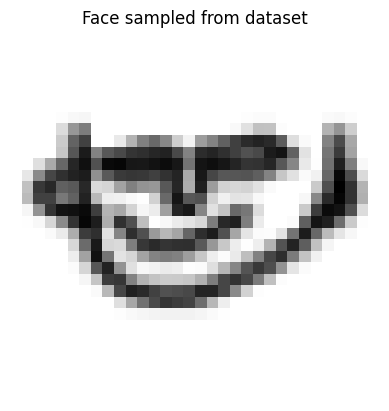

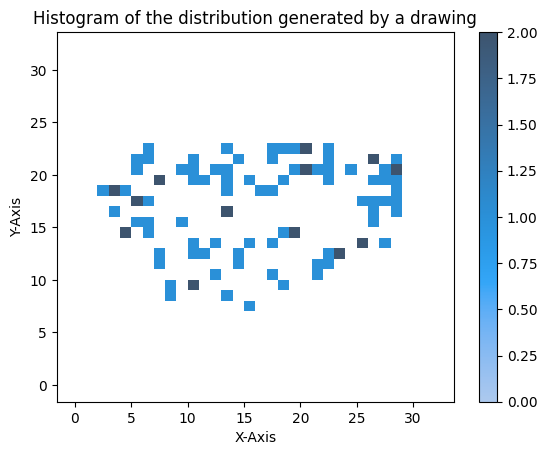

In [9]:
def get_sampler(sampler, n_data, plot=True, exp=None):
    face = sampler.draw()

    data = face.sample((n_data,))

    shape = face.shape
    data_coords = face.enumerate_support_()[data].cpu().numpy() + np.random.randn(n_data, 2) * 0.1

    
    if plot:
        fig_ax1 = plotters.plot_draw(face, title="Face sampled from dataset")
        ax2 = plotters.plot_histogram_from_points(data_coords, rotate=True, shape=shape, histplot_kwargs=dict(bins=shape[0]))

    return face, data, fig_ax1, (ax2.figure, ax2)

_, _, (fig1, ax1), (fig2, ax2) = get_sampler(ds_sampler, 100)

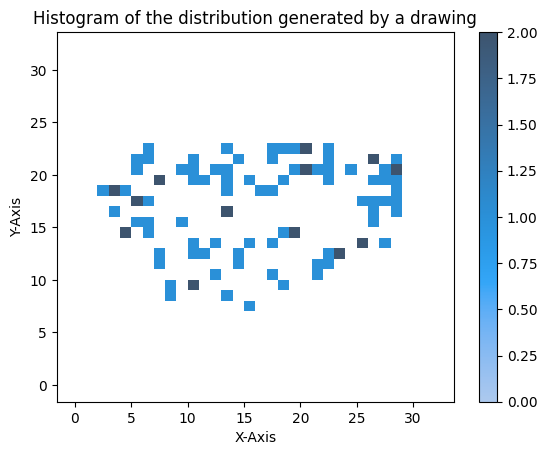

In [10]:
fig2

## Definir red neuronal generadora y transformador

Se define la red neuronal de la misma manera que en el notebook anterior

In [11]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

DS_NAME = "data"
FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

torch.float64


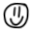

In [12]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(torch.float64),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])

out: DistributionDraw = transform_out(m)
print(out.dtype)
out

# Experimentos

## Experimento 1

In [13]:
EXP = 1

NUTS_POSTERIOR_PATH = NUTS_PATH / f"exp-{EXP}-burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}"
NUTS_POSTERIOR_PATH = NUTS_POSTERIOR_PATH.with_suffix(".pkl.gz")
print(NUTS_POSTERIOR_PATH)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS/exp-1-burn-2_000-num_samples-50_000-n_walkers-8.pkl.gz


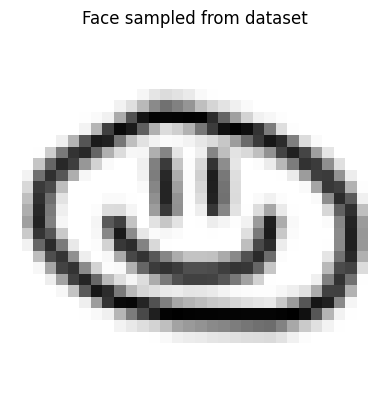

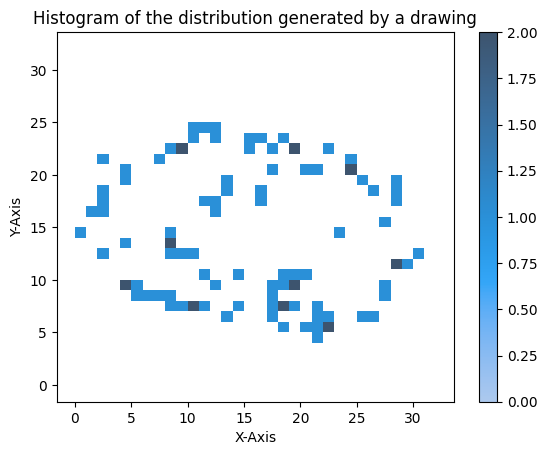

In [14]:
_, data, (fig1, _), (fig2, _) = get_sampler(ds_sampler, 100)

In [15]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorSampler(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data,
    )
    
    post_pi_n.run(
        n_steps=NUM_SAMPLES,
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorSampler.load(NUTS_POSTERIOR_PATH)
    post_pi_n.fit(G, transform_out_, noise_sampler, data)

post_pi_n

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.05551675707101822--- |  1996/52000 | 33.07       
0d:00:14:36 | 0d:00:00:00 | #################### | 52000/52000 | 59.32       
Acceptance Rate 0.60
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.06048978865146637--- |  1997/52000 | 72.22       
0d:00:13:54 | 0d:00:00:00 | #################### | 52000/52000 | 62.28       
Acceptance Rate 0.59
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.041430674493312836-- |  1997/52000 | 73.68       
0d:00:13:54 | 0d:00:00:00 | #################### | 52000/52000 | 62.32       
Acceptance Rate 0.68
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples    

2024-04-23 16:53:20,689: WARNING [bwb.distributions.distribution_samplers:573]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/distribution_samplers.py:94: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
ic| toc - tic: 93.42207993100237


NUTSPosteriorSampler(n_data=100, len_chain=50_000, n_steps=400_000, n_walkers=8)

In [16]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

2024-04-23 16:54:55,081: WARNING [bwb.utils:189]
> The chain is shorter than 50 times the integrated autocorrelation time for 127 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: tensor([1335.3892, 1575.1649, 1470.5869, 1247.0325, 1644.0319, 1773.7566,
        1228.1583, 1266.6208, 1618.9724, 1546.3696, 1762.6022, 1339.5839,
        1541.1835, 1537.4854,  982.7142, 1236.2800, 1323.5524, 1464.6794,
        1774.8464, 1928.5895, 1435.9797, 1141.7540, 1138.2987, 1061.7285,
        1554.2292, 1655.1764, 1729.1534, 2140.5017, 1707.0142, 1612.1127,
        1572.3105, 1709.7280, 1554.4009, 1070.2712, 1690.4944, 1443.1541,
        1326.4706, 1892.7924, 1931.9967, 1654.8899, 1283.9834, 1665.8125,
        2074.1853, 1460.7327, 1495.5928, 1403.7454, 1291.9052, 2162.9651,
        1644.9602, 1059.1272, 1410.0857, 1539.1697, 1186.1279, 1285.0813,
        1683.9832, 1549.5182, 1742.2175, 1329.7863, 1587.3954, 2083.8733,
        1687.2218, 1280.6526, 2035.7830, 12

1520


In [17]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / 10))

NUTSPosteriorSampler(n_data=100, n_cached_samples=2_632, len_chain=50_000, n_steps=400_000, n_walkers=8)

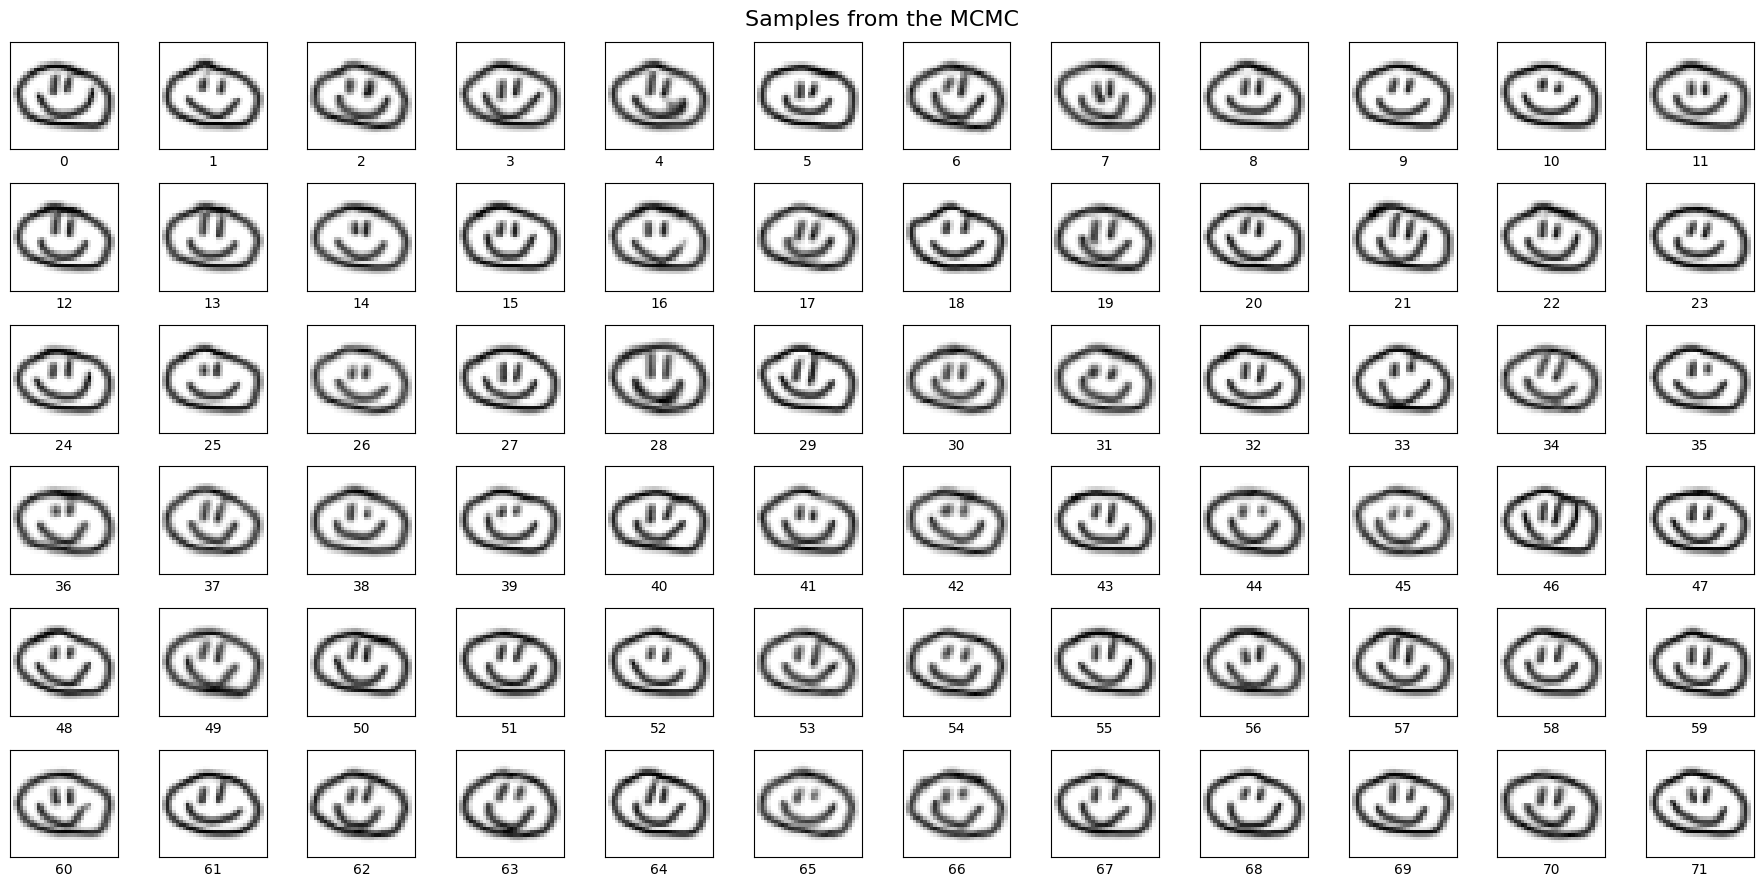

In [18]:
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    post_pi_n.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the MCMC"
)

In [19]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"exp-{EXP}-{post_pi_n.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))
    PATH_TO_SAVE_FIG1 = IMGS_PATH / f"exp-{EXP}-face"
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".pdf"))
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".png"))
    PATH_TO_SAVE_FIG2 = IMGS_PATH / f"exp-{EXP}-hist"
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".pdf"))
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".png"))

## Experimento 2

In [20]:
EXP = 2

NUTS_POSTERIOR_PATH = NUTS_PATH / f"exp-{EXP}-burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}"
NUTS_POSTERIOR_PATH = NUTS_POSTERIOR_PATH.with_suffix(".pkl.gz")
print(NUTS_POSTERIOR_PATH)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS/exp-2-burn-2_000-num_samples-50_000-n_walkers-8.pkl.gz


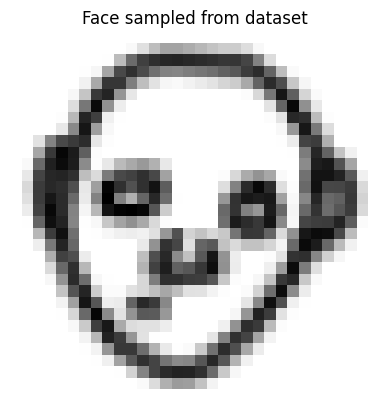

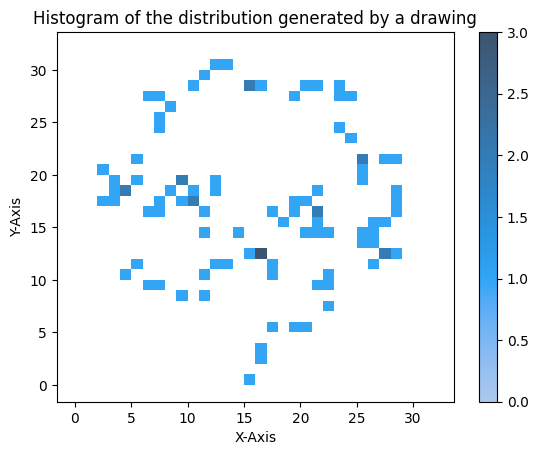

In [22]:
_, data, (fig1, _), (fig2, _) = get_sampler(ds_sampler, 100)

In [23]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorSampler(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data,
    )
    
    post_pi_n.run(
        n_steps=NUM_SAMPLES,
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorSampler.load(NUTS_POSTERIOR_PATH)
    post_pi_n.fit(G, transform_out_, noise_sampler, data)

post_pi_n

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.029292602092027664-- |  1989/52000 | 65.85       
0d:00:14:26 | 0d:00:00:00 | #################### | 52000/52000 | 60.00       
Acceptance Rate 0.74
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.04268079251050949--- |  1997/52000 | 72.40       
0d:00:14:47 | 0d:00:00:00 | #################### | 52000/52000 | 58.57       
Acceptance Rate 0.64
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.0414733812212944---- |  1989/52000 | 69.82       
0d:00:13:25 | 0d:00:00:00 | #################### | 52000/52000 | 64.52       
Acceptance Rate 0.63
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples    

2024-04-23 18:46:24,095: WARNING [bwb.distributions.distribution_samplers:573]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.



Acceptance Rate 0.59


/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/distribution_samplers.py:94: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
ic| toc - tic: 99.42714761100069


NUTSPosteriorSampler(n_data=100, len_chain=50_000, n_steps=400_000, n_walkers=8)

In [24]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

2024-04-23 18:48:04,631: WARNING [bwb.utils:189]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: tensor([2612.2654, 2315.2151, 3492.0325, 1574.7413, 1999.6456, 2320.0034,
        2294.1367, 1291.0499, 2128.9583, 2480.9946, 2328.7561, 1929.1576,
        1597.9156, 2352.1084, 1870.2775, 1414.1329, 2023.7506, 1668.9128,
        2106.1533, 2439.8225, 2271.0598, 1633.5659, 2434.1162, 1878.9924,
        1876.5861, 2776.4512, 1880.3881, 2347.5730, 2208.5972, 2281.5601,
        2776.9668, 2382.5835, 1897.9733, 1929.5078, 2898.0134, 2580.5371,
        1756.7047, 2569.3843, 2631.0483, 1858.5891, 1573.3320, 2129.1367,
        2572.8674, 1986.8982, 1930.0444, 1877.3983, 1633.9060, 2457.7134,
        2726.0845, 1987.8800, 1520.6000, 2194.3687, 1944.9707, 2537.4709,
        2344.4348, 2699.7937, 2349.9761, 1748.7538, 1992.9991, 1736.4364,
        1735.4609, 1244.0280, 3191.3777, 18

2137


In [25]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / 10))

NUTSPosteriorSampler(n_data=100, n_cached_samples=1_880, len_chain=50_000, n_steps=400_000, n_walkers=8)

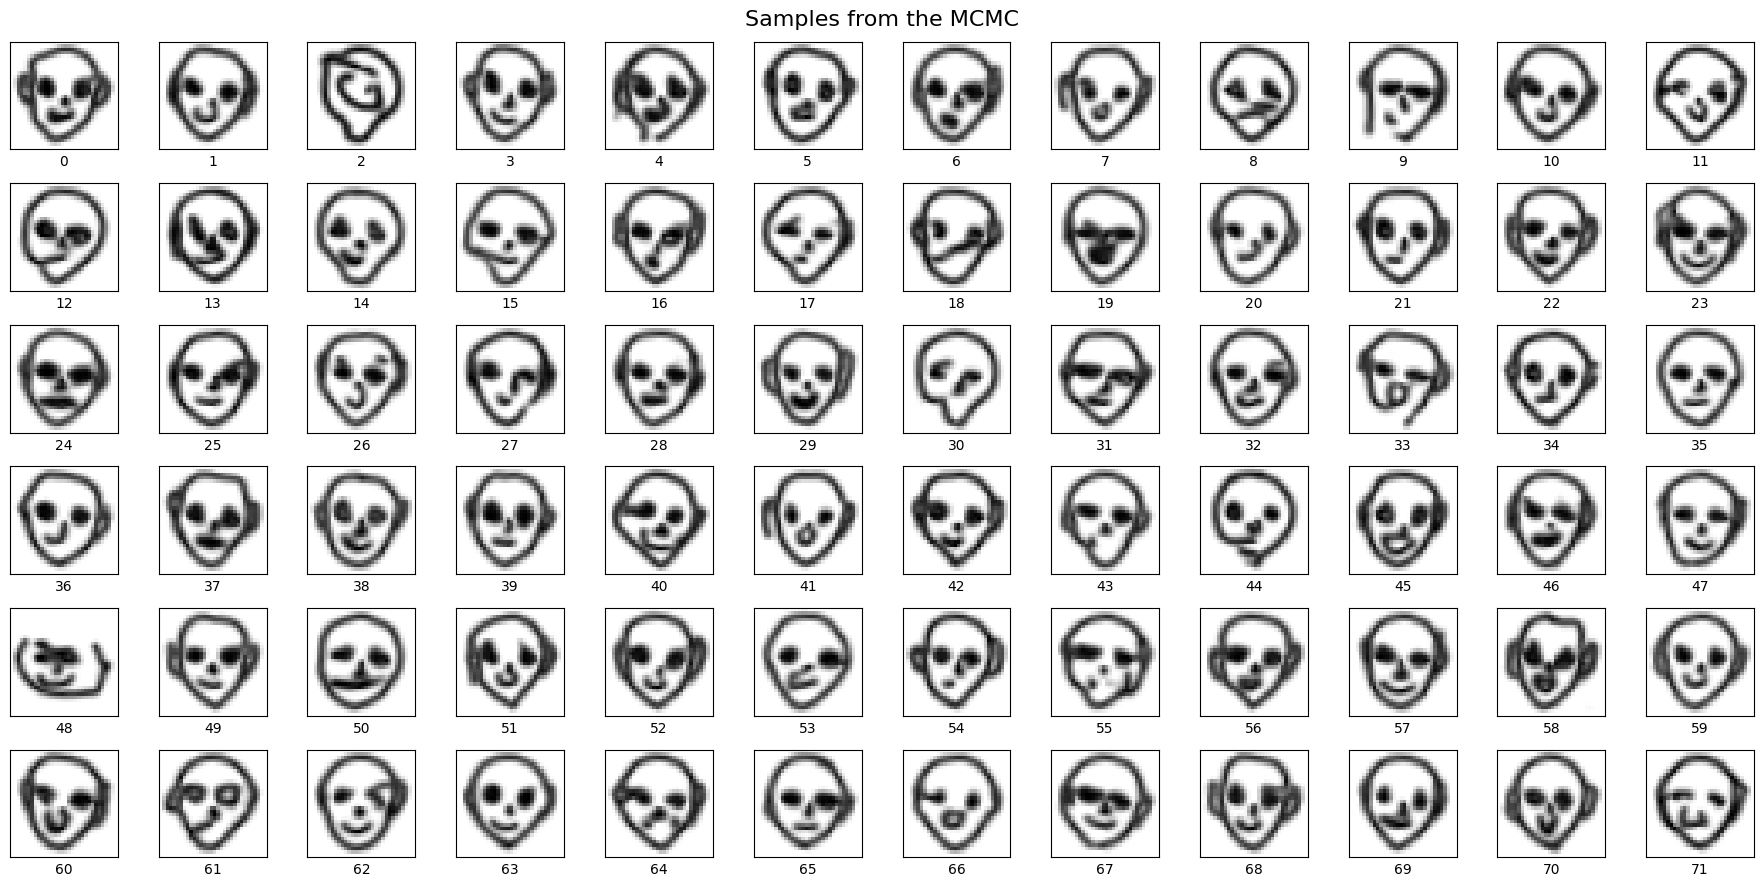

In [26]:
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    post_pi_n.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the MCMC"
)

In [27]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"exp-{EXP}-{post_pi_n.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))
    PATH_TO_SAVE_FIG1 = IMGS_PATH / f"exp-{EXP}-face"
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".pdf"))
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".png"))
    PATH_TO_SAVE_FIG2 = IMGS_PATH / f"exp-{EXP}-hist"
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".pdf"))
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".png"))

## Experimento 3

In [28]:
EXP = 3

NUTS_POSTERIOR_PATH = NUTS_PATH / f"exp-{EXP}-burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}"
NUTS_POSTERIOR_PATH = NUTS_POSTERIOR_PATH.with_suffix(".pkl.gz")
print(NUTS_POSTERIOR_PATH)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS/exp-3-burn-2_000-num_samples-50_000-n_walkers-8.pkl.gz


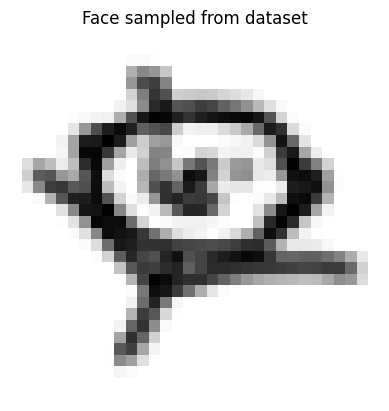

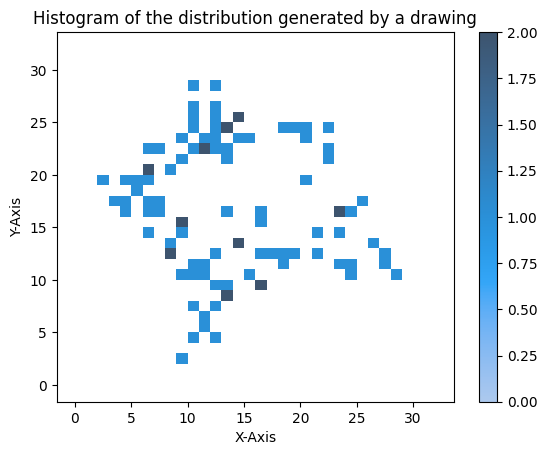

In [29]:
_, data, (fig1, _), (fig2, _) = get_sampler(ds_sampler, 100)

In [30]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorSampler(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data,
    )
    
    post_pi_n.run(
        n_steps=NUM_SAMPLES,
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorSampler.load(NUTS_POSTERIOR_PATH)
    post_pi_n.fit(G, transform_out_, noise_sampler, data)

post_pi_n

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.023299001157283783-- |  2000/52000 | 45.52       
0d:00:16:57 | 0d:00:00:00 | #################### | 52000/52000 | 51.10       
Acceptance Rate 0.62
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.02832230180501938--- |  1988/52000 | 74.47       
0d:00:13:25 | 0d:00:00:00 | #################### | 52000/52000 | 64.57       
Acceptance Rate 0.63
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.04771769046783447--- |  1988/52000 | 57.32       
0d:00:14:18 | 0d:00:00:00 | #################### | 52000/52000 | 60.55       
Acceptance Rate 0.41
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples    

2024-04-23 20:45:50,450: WARNING [bwb.distributions.distribution_samplers:573]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.



Acceptance Rate 0.61


/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/distribution_samplers.py:94: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
ic| toc - tic: 93.62099756200041


NUTSPosteriorSampler(n_data=100, len_chain=50_000, n_steps=400_000, n_walkers=8)

In [31]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

2024-04-23 20:47:25,000: WARNING [bwb.utils:189]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: tensor([3215.0854, 3958.2329, 3265.6904, 3068.1926, 4320.1157, 3627.6819,
        4318.2446, 3265.2234, 3235.6907, 3777.7510, 3148.8845, 3354.0945,
        3435.7690, 3018.1965, 3636.0891, 3260.5215, 3600.5635, 3226.3545,
        3056.1907, 3541.3174, 3693.5293, 2010.7616, 2469.7395, 2639.0481,
        2912.3464, 4272.6870, 2963.6357, 3616.3140, 3767.1870, 3522.8167,
        4667.1284, 3394.6719, 3269.8220, 3334.9165, 2771.9688, 2442.9980,
        4825.9048, 2553.6504, 3765.6792, 2864.2949, 4540.2500, 3821.2747,
        3380.2493, 1987.1129, 3619.9861, 4019.1738, 3380.0081, 3759.6477,
        3910.7590, 3512.2002, 3255.1372, 3875.0229, 3527.3796, 3787.6584,
        3537.9438, 3837.7852, 2998.7031, 2740.6531, 3271.1885, 3591.9504,
        2245.5647, 2602.7441, 4657.3120, 41

3420


In [32]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / 10))

NUTSPosteriorSampler(n_data=100, n_cached_samples=1_176, len_chain=50_000, n_steps=400_000, n_walkers=8)

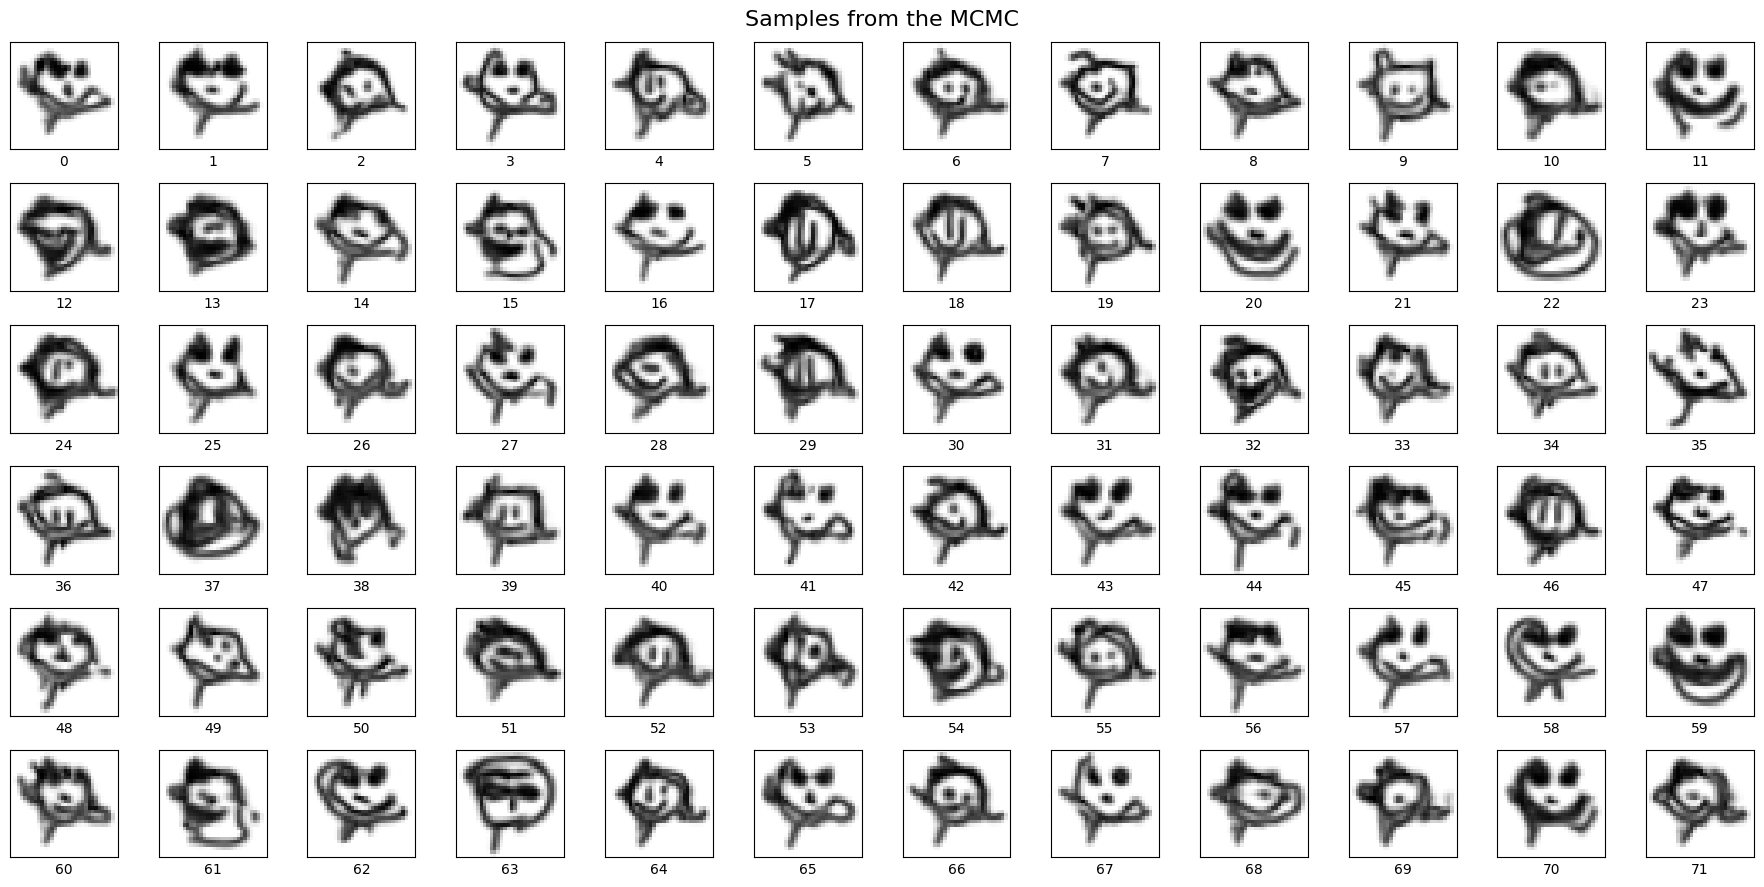

In [33]:
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    post_pi_n.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the MCMC"
)

In [34]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"exp-{EXP}-{post_pi_n.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))
    PATH_TO_SAVE_FIG1 = IMGS_PATH / f"exp-{EXP}-face"
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".pdf"))
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".png"))
    PATH_TO_SAVE_FIG2 = IMGS_PATH / f"exp-{EXP}-hist"
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".pdf"))
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".png"))

## Experimento 4

In [35]:
EXP = 4

NUTS_POSTERIOR_PATH = NUTS_PATH / f"exp-{EXP}-burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}"
NUTS_POSTERIOR_PATH = NUTS_POSTERIOR_PATH.with_suffix(".pkl.gz")
print(NUTS_POSTERIOR_PATH)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS/exp-4-burn-2_000-num_samples-50_000-n_walkers-8.pkl.gz


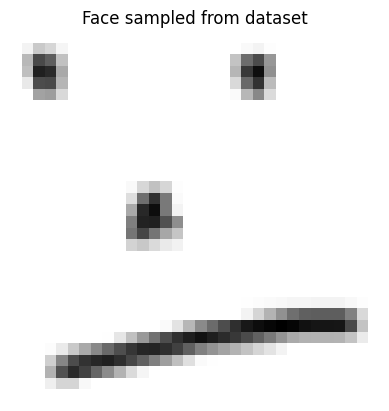

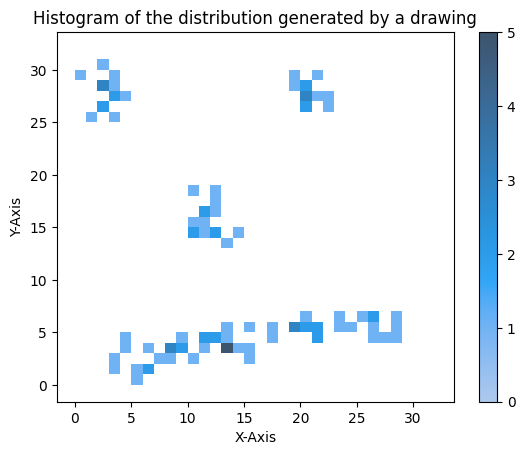

In [36]:
_, data, (fig1, _), (fig2, _) = get_sampler(ds_sampler, 100)

In [37]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorSampler(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data,
    )
    
    post_pi_n.run(
        n_steps=NUM_SAMPLES,
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorSampler.load(NUTS_POSTERIOR_PATH)
    post_pi_n.fit(G, transform_out_, noise_sampler, data)

post_pi_n

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.019952476024627686-- |  1999/52000 | 42.58       
0d:00:16:05 | 0d:00:00:00 | #################### | 52000/52000 | 53.89       
Acceptance Rate 0.49
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.02541726641356945--- |  1994/52000 | 76.62       
0d:00:14:27 | 0d:00:00:00 | #################### | 52000/52000 | 59.97       
Acceptance Rate 0.40
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.02754420042037964--- |  1990/52000 | 67.89       
0d:00:13:35 | 0d:00:00:00 | #################### | 52000/52000 | 63.79       
Acceptance Rate 0.36
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples    

2024-04-23 22:45:58,630: WARNING [bwb.distributions.distribution_samplers:573]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/distribution_samplers.py:94: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
ic| toc - tic: 85.11793639100506


NUTSPosteriorSampler(n_data=100, len_chain=50_000, n_steps=400_000, n_walkers=8)

In [38]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

2024-04-23 22:47:25,049: WARNING [bwb.utils:189]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: tensor([4403.9272, 4178.5820, 4188.3174, 3187.6296, 4383.1377, 4287.7593,
        4760.9790, 3985.5786, 4237.1187, 4557.1270, 3533.7649, 3425.1772,
        4249.0391, 4352.7251, 4139.9331, 3783.6577, 3033.8906, 4031.1743,
        4602.5708, 4284.8892, 4401.7827, 3463.4927, 3957.7717, 3211.6133,
        4538.3301, 4787.5674, 3405.2881, 5099.7231, 3832.7083, 3324.0540,
        4506.5439, 2919.6743, 3815.0647, 4701.8599, 3831.7195, 4252.5630,
        3971.4807, 3829.6460, 4324.4219, 4053.6750, 4037.4023, 3563.4563,
        3937.8743, 3269.5679, 3930.8005, 2881.1106, 4632.8135, 4862.7949,
        3664.1748, 4933.1436, 4492.7910, 4574.1812, 2653.3628, 5205.4868,
        3418.7781, 4076.2590, 3401.3689, 3276.1003, 3658.7759, 3201.1475,
        4074.9910, 2874.3987, 4215.3018, 26

3966


In [39]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / 10))

NUTSPosteriorSampler(n_data=100, n_cached_samples=1_016, len_chain=50_000, n_steps=400_000, n_walkers=8)

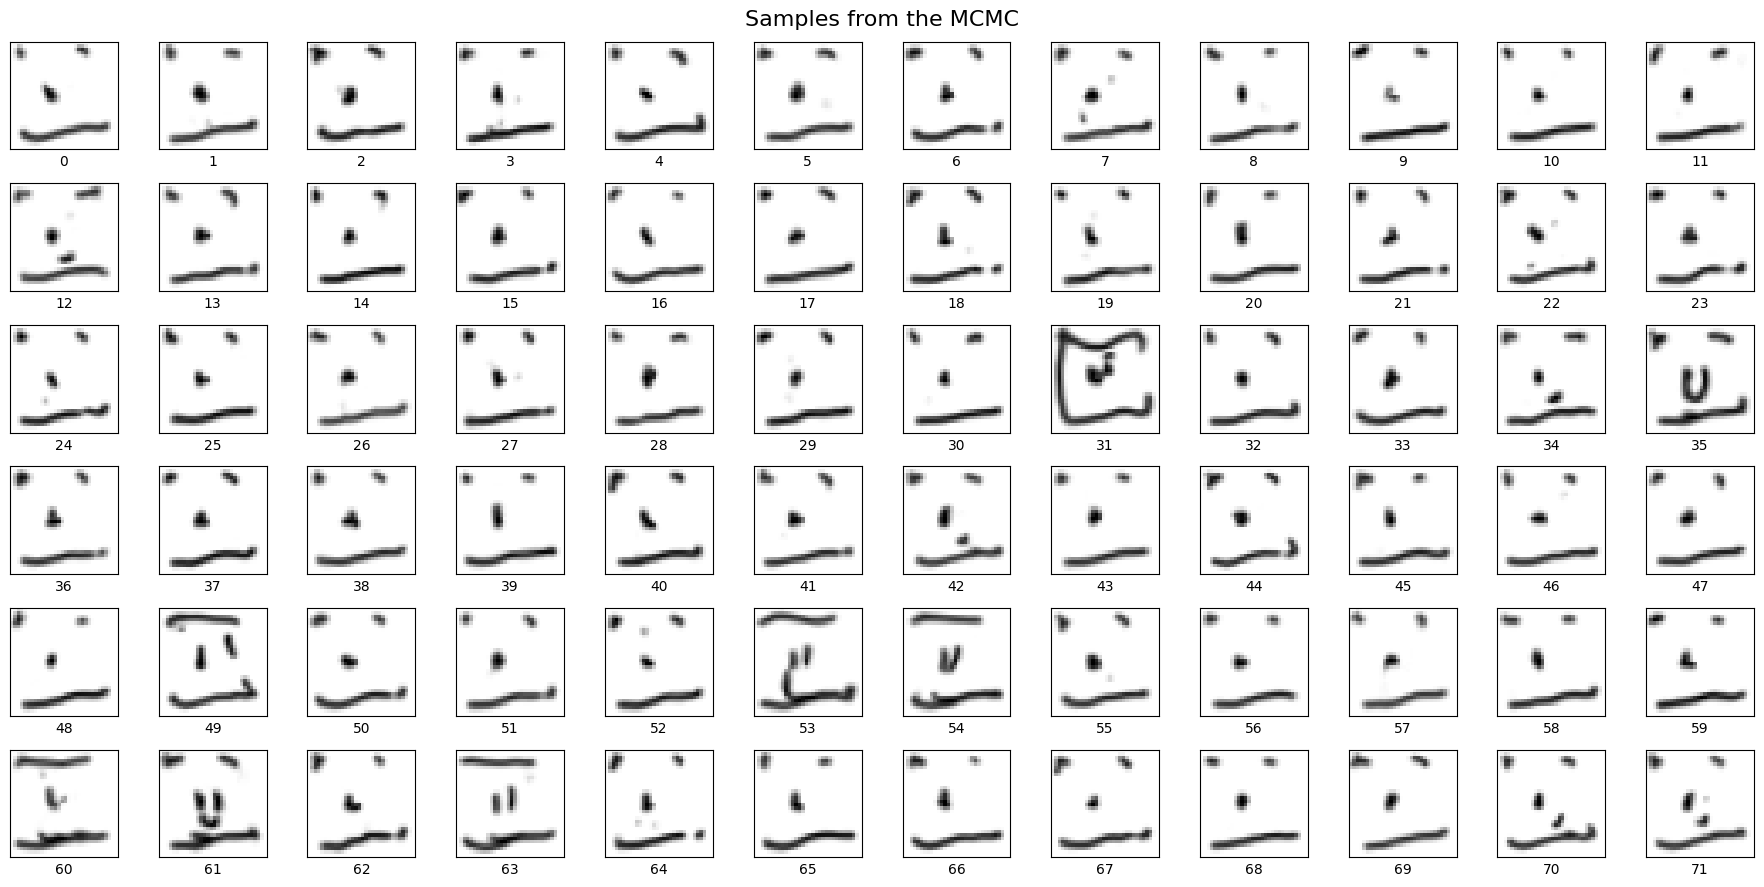

In [40]:
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    post_pi_n.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the MCMC"
)

In [41]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"exp-{EXP}-{post_pi_n.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))
    PATH_TO_SAVE_FIG1 = IMGS_PATH / f"exp-{EXP}-face"
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".pdf"))
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".png"))
    PATH_TO_SAVE_FIG2 = IMGS_PATH / f"exp-{EXP}-hist"
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".pdf"))
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".png"))

## Experimento 5

In [42]:
EXP = 5

NUTS_POSTERIOR_PATH = NUTS_PATH / f"exp-{EXP}-burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}"
NUTS_POSTERIOR_PATH = NUTS_POSTERIOR_PATH.with_suffix(".pkl.gz")
print(NUTS_POSTERIOR_PATH)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS/exp-5-burn-2_000-num_samples-50_000-n_walkers-8.pkl.gz


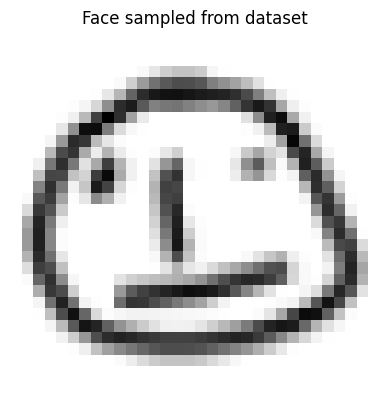

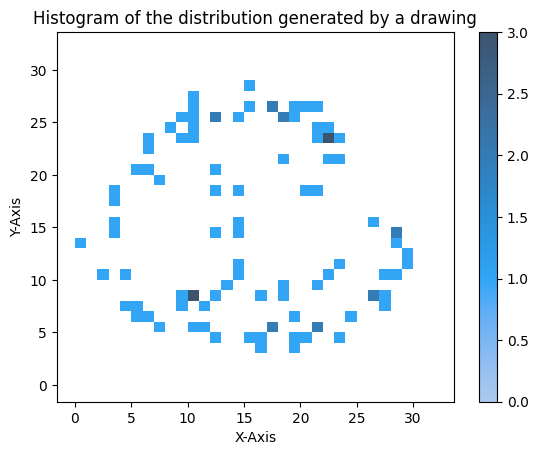

In [43]:
_, data, (fig1, _), (fig2, _) = get_sampler(ds_sampler, 100)

In [44]:
if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorSampler(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data,
    )
    
    post_pi_n.run(
        n_steps=NUM_SAMPLES,
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorSampler.load(NUTS_POSTERIOR_PATH)
    post_pi_n.fit(G, transform_out_, noise_sampler, data)

post_pi_n

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.05889730527997017--- |  1989/52000 | 75.13       
0d:00:11:42 | 0d:00:00:00 | #################### | 52000/52000 | 74.00       
Acceptance Rate 0.59
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.039521053433418274-- |  1991/52000 | 75.37       
0d:00:12:22 | 0d:00:00:00 | #################### | 52000/52000 | 70.02       
Acceptance Rate 0.70
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.05484621599316597--- |  1987/52000 | 76.60       
0d:00:11:49 | 0d:00:00:00 | #################### | 52000/52000 | 73.27       
Acceptance Rate 0.59
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples    

2024-04-24 00:34:26,263: WARNING [bwb.distributions.distribution_samplers:573]
> The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/distribution_samplers.py:94: RuntimeWarning: The generator_, transform_out_ and noise_sampler_ attributes will not be saved. Use fit method to fit these attributes.
  pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
ic| toc - tic: 94.05105907999678


NUTSPosteriorSampler(n_data=100, len_chain=50_000, n_steps=400_000, n_walkers=8)

In [45]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

2024-04-24 00:36:01,401: WARNING [bwb.utils:189]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: tensor([1701.9010, 1630.3057, 1575.0795, 1071.0481, 1424.9346, 1803.9911,
        1282.2076, 1196.0669, 1644.5226, 1467.0457, 1214.4216, 1844.7593,
        1381.5795, 1724.7153, 1492.6431, 1370.1116, 1780.8528, 1067.3440,
        1782.5658, 2003.9891, 1696.1592, 1140.2634, 1566.6816, 1477.0100,
        1682.1559, 1520.7288, 1708.2217, 2212.3796, 1619.6711, 1587.4237,
        2314.7305, 2307.1960, 1407.7021, 1321.0322, 1721.7617, 1662.8140,
        1248.2125, 2099.3657, 2539.9619, 1487.3220, 1943.9717, 2017.5522,
        1901.2941, 1569.2507, 1844.2654, 1117.4507, 1058.4713, 1371.9219,
        3197.5078, 1653.8425, 1307.6552, 1382.6833, 1473.4170, 1787.2360,
        1848.5500, 2137.1609, 1980.0433, 1622.4335, 1644.6492, 1859.5471,
        1456.7004, 1347.4296, 2834.7061, 13

1664


In [46]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / 10))

NUTSPosteriorSampler(n_data=100, n_cached_samples=2_416, len_chain=50_000, n_steps=400_000, n_walkers=8)

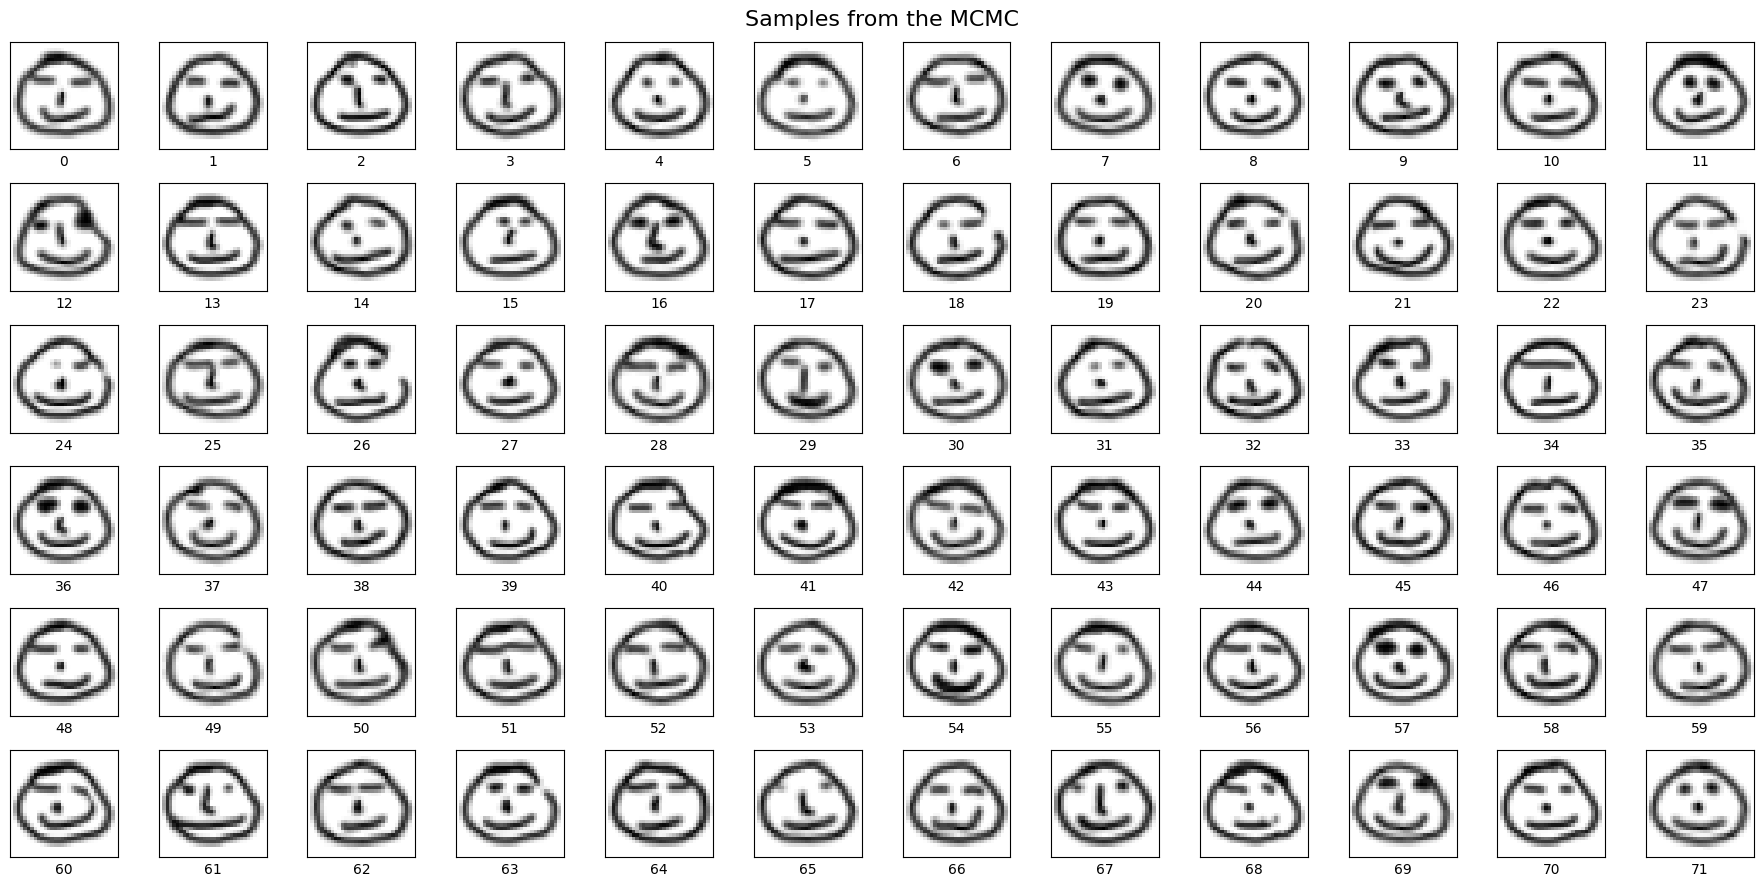

In [47]:
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    post_pi_n.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the MCMC"
)

In [48]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"exp-{EXP}-{post_pi_n.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))
    PATH_TO_SAVE_FIG1 = IMGS_PATH / f"exp-{EXP}-face"
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".pdf"))
    fig1.savefig(PATH_TO_SAVE_FIG1.with_suffix(".png"))
    PATH_TO_SAVE_FIG2 = IMGS_PATH / f"exp-{EXP}-hist"
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".pdf"))
    fig2.savefig(PATH_TO_SAVE_FIG2.with_suffix(".png"))